# Churn Prediction Project: Telco Customer Churn
# A step-by-step Jupyter-style notebook with full code, explanations, and alternative methods.

# 1. Setup and Imports
# Purpose: Load required libraries and configure environment.

In [1]:

import pandas as pd  # data manipulation
import numpy as np   # numerical operations
import matplotlib.pyplot as plt  # plotting
import seaborn as sns  # statistical visualizations
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans


# Alternative libraries or tools:
# - Use plotly for interactive charts.
# - Try XGBoost or LightGBM instead of GradientBoostingClassifier.

# 2. Data Loading & Initial Cleaning
# Purpose: Read the CSV and inspect missing or inconsistent values.


In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')  # replace with your path
print(f"Data shape: {df.shape}")
df.head()

# Check for missing values
print(df.isnull().sum())

# Identify inconsistent entries in 'TotalCharges'
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df['TotalCharges'].isnull().sum(), "missing after coercion")

# Handle missing 'TotalCharges' by imputing zero or median
tc_imputer = SimpleImputer(strategy='median')
df['TotalCharges'] = tc_imputer.fit_transform(df[['TotalCharges']])

Data shape: (7043, 21)
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64
11 missing after coercion



# Alternative approaches:
# - Drop rows with missing TotalCharges if few (< 1%).
# - Use KNN-imputation for more context-aware filling.

# 3. Exploratory Data Analysis (EDA)
# Purpose: Understand distributions, relationships, and potential predictors.

# 3.1 Numerical Distributions

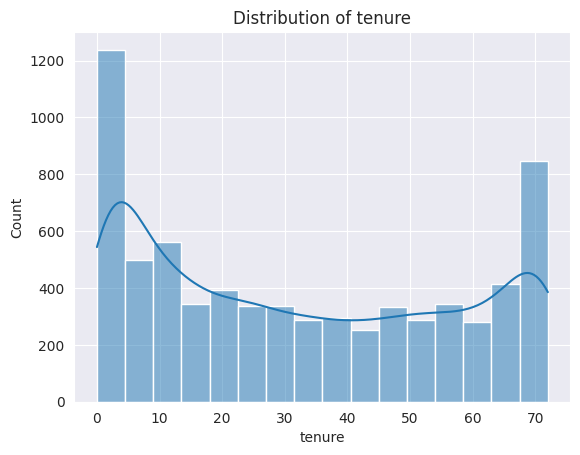

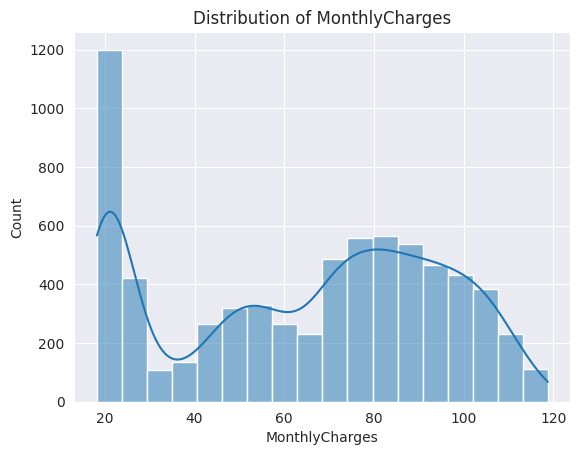

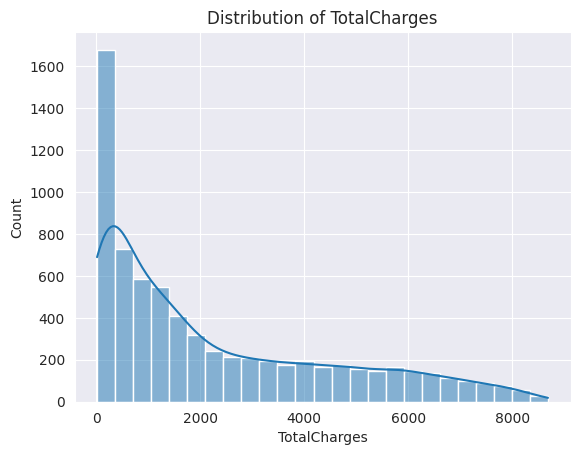

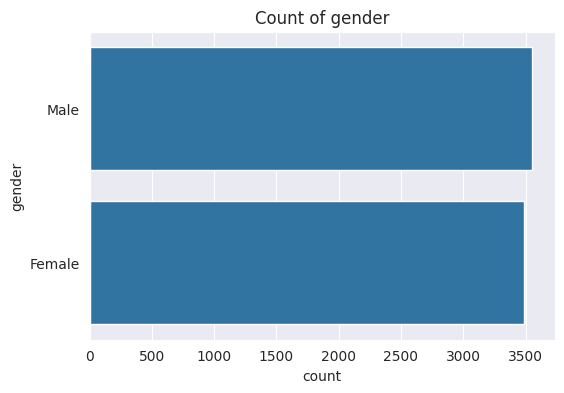

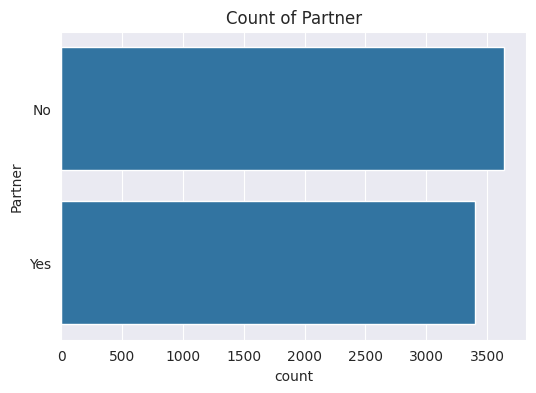

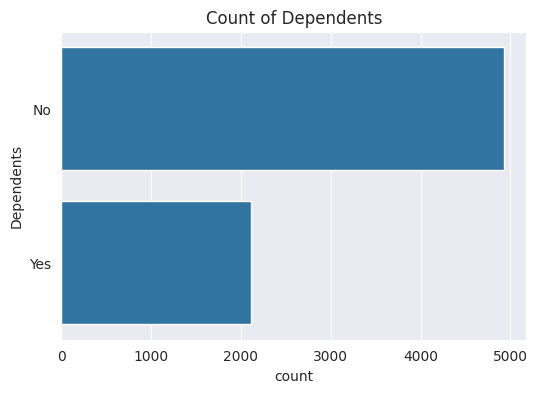

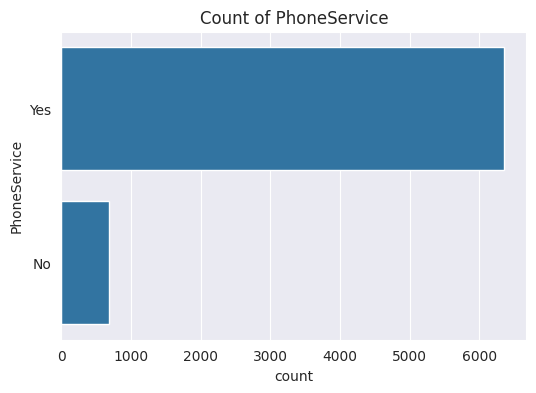

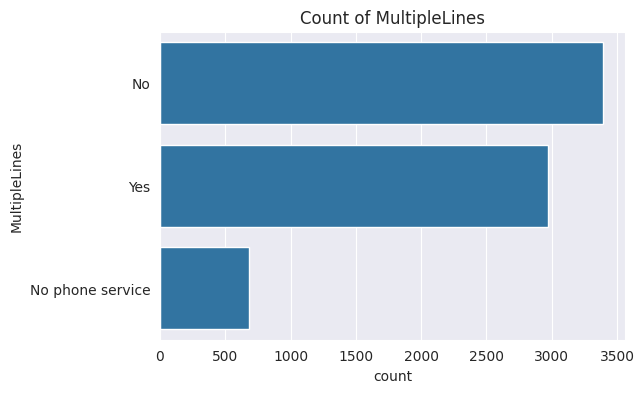

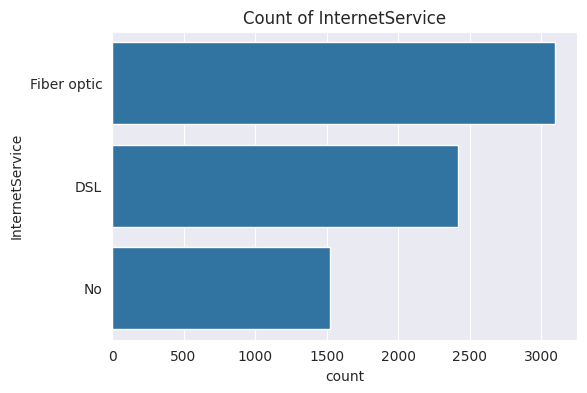

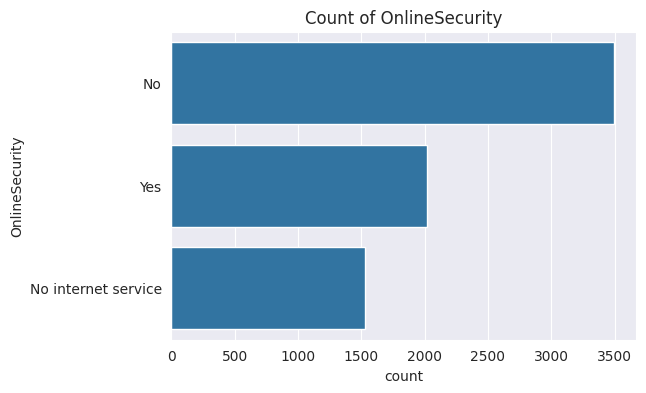

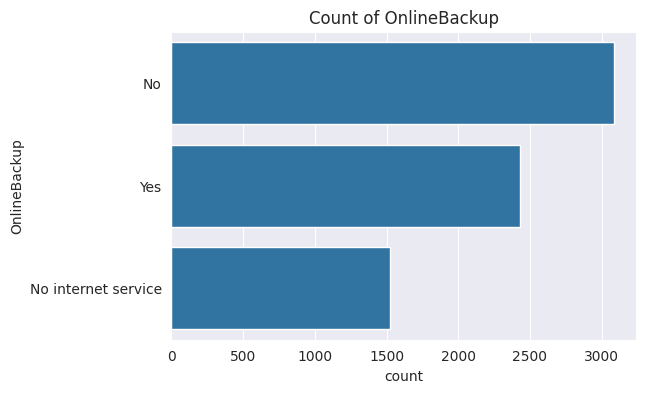

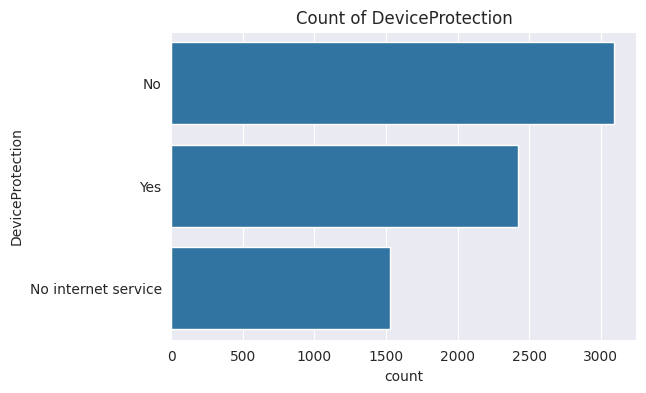

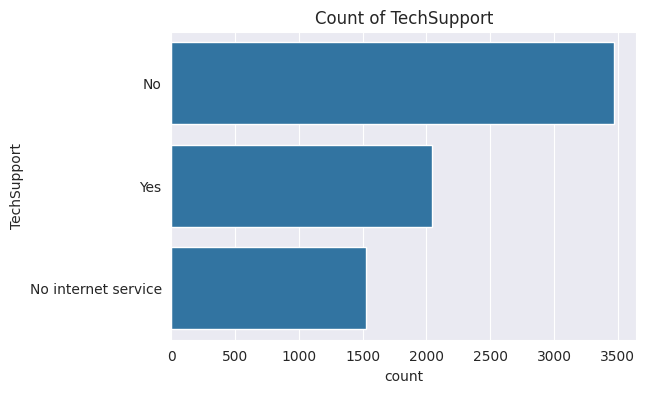

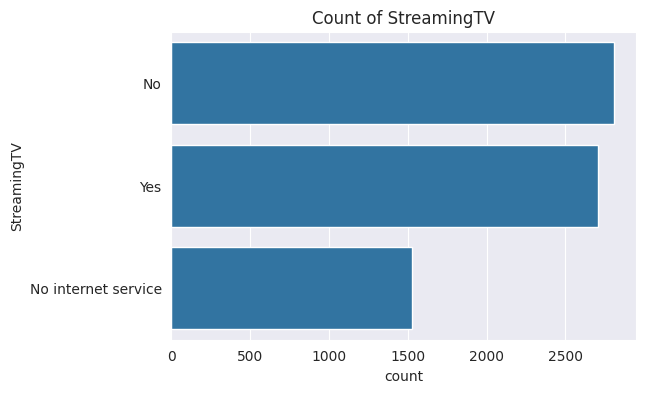

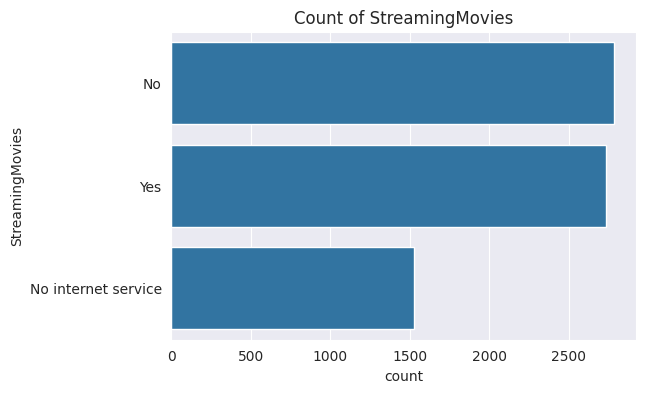

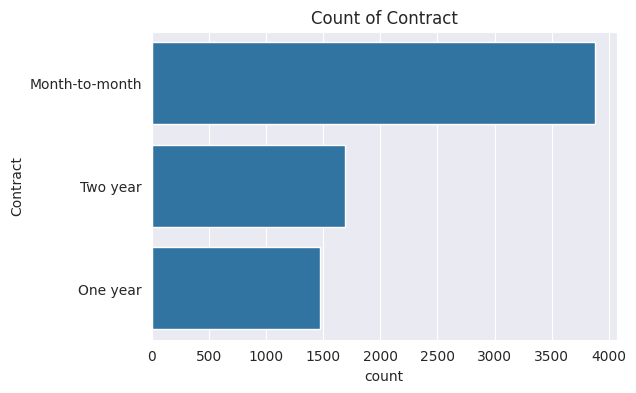

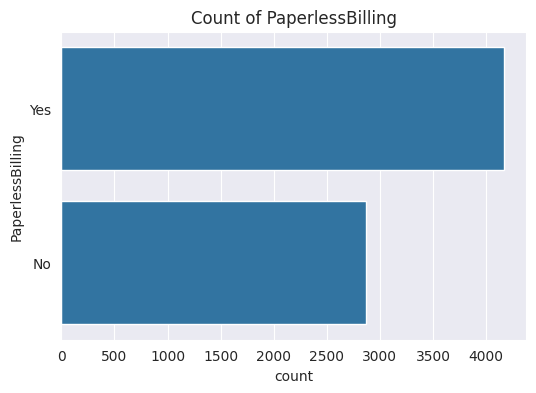

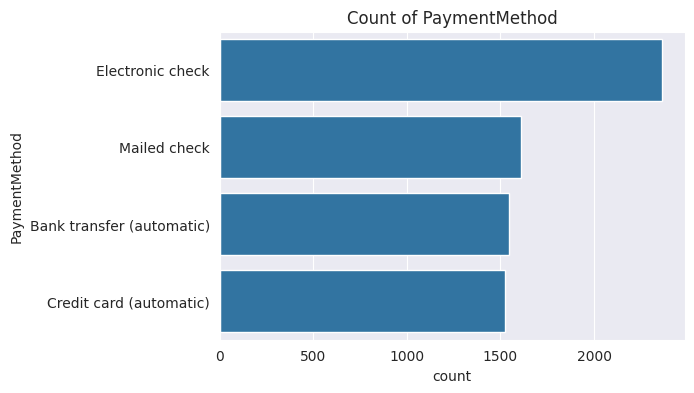

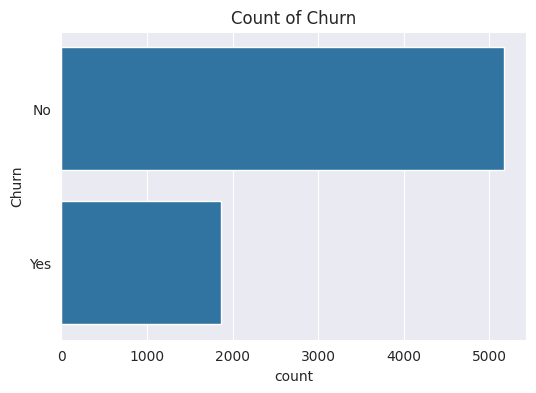

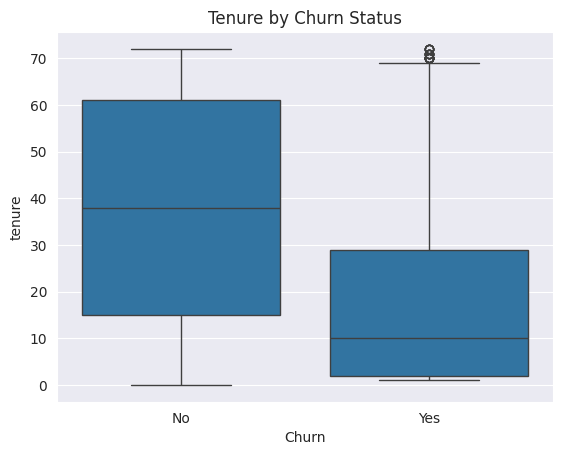

In [3]:
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_cols].describe()

# Histograms
for col in numeric_cols:
    plt.figure()
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

# 3.2 Categorical Counts
cat_cols = [c for c in df.columns if df[c].dtype == 'object' and c != 'customerID']
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f'Count of {col}')
    plt.show()

# 3.3 Churn vs Tenure scatter
plt.figure()
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title('Tenure by Churn Status')
plt.show()


# Alternative EDA:
# - Correlation heatmap for numeric features.
# - Pairplot for top features.

# 4. Feature Encoding
# Purpose: Convert categorical variables into numeric representations.

# Binary mapping for Yes/No columns

In [4]:
yn_cols = ['Partner','Dependents','PhoneService','PaperlessBilling','Churn']
for col in yn_cols:
    df[col] = df[col].map({'Yes':1,'No':0})

# Encode gender column (Male/Female)
df['gender'] = df['gender'].map({'Female': 0, 'Male': 1})

# One-hot encode remaining
multi_cat = ['InternetService','Contract','PaymentMethod','MultipleLines',
             'OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
             'StreamingTV','StreamingMovies']
df = pd.get_dummies(df, columns=multi_cat, drop_first=True)


# Alternative:
# - Use sklearn OneHotEncoder within ColumnTransformer.
# - Target encoding for high-cardinality categories.

# 5. Feature Selection
# Purpose: Identify the most informative features to simplify the model.

In [5]:
# Separate X and y
y = df['Churn']
X = df.drop(columns=['customerID','Churn'])

# Univariate selection with chi2 (for positive features) and ANOVA F-test
test = SelectKBest(score_func=f_classif, k=10)
fit = test.fit(X, y)
scores = pd.Series(fit.scores_, index=X.columns)
top10 = scores.nlargest(10).index.tolist()
print("Top 10 features:", top10)

Top 10 features: ['tenure', 'InternetService_Fiber optic', 'Contract_Two year', 'PaymentMethod_Electronic check', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineBackup_No internet service', 'DeviceProtection_No internet service', 'TechSupport_No internet service', 'StreamingTV_No internet service']



# Alternative:
# - Use tree-based feature importances from RandomForest.
# - Recursive Feature Elimination (RFE).

# 6. Train/Test Split & Scaling
# Purpose: Prepare data for training and ensure fair scaling.


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X[top10], y, test_size=0.3, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Alternative scaling:
# - MinMaxScaler (for tree-based models not required).
# - RobustScaler (handles outliers).

# 7. Modeling
# Purpose: Train and compare multiple classifiers.


In [7]:
models = {
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    results[name] = {
        'accuracy': accuracy_score(y_test, preds),
        'precision': precision_score(y_test, preds),
        'recall': recall_score(y_test, preds),
        'f1': f1_score(y_test, preds)
    }

results_df = pd.DataFrame(results).T
print(results_df)

                   accuracy  precision    recall        f1
KNN                0.747752   0.534146  0.390374  0.451081
Decision Tree      0.781827   0.614155  0.479501  0.538539
Random Forest      0.777567   0.590818  0.527629  0.557439
Gradient Boosting  0.794132   0.644495  0.500891  0.563691



# Alternative:
# - Hyperparameter tuning with GridSearchCV per model.
# - Cross-validation scoring instead of single split.

# 8. Model Evaluation & ROC
# Purpose: Deep dive into the best model's performance.


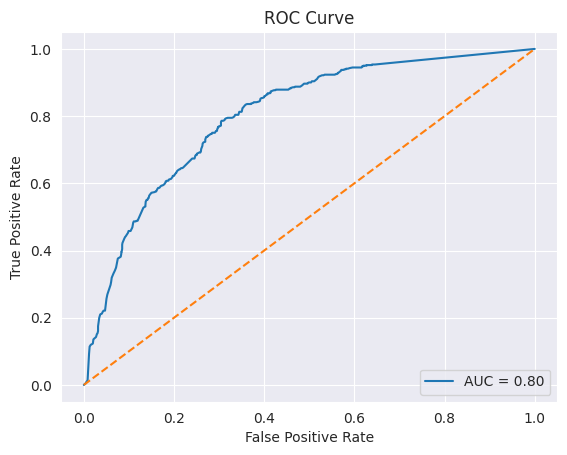

              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1552
           1       0.59      0.53      0.56       561

    accuracy                           0.78      2113
   macro avg       0.71      0.70      0.70      2113
weighted avg       0.77      0.78      0.77      2113



In [8]:
best_model = RandomForestClassifier(random_state=42)
best_model.fit(X_train_scaled, y_train)
probs = best_model.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

print(classification_report(y_test, best_model.predict(X_test_scaled)))


# 9. Clustering Analysis
# Purpose: Segment customers to uncover groups with distinct behaviors.


In [9]:
cluster_features = X[top10]
km = KMeans(n_clusters=4, random_state=42)
clusters = km.fit_predict(cluster_features)
df['Cluster'] = clusters

# Profile clusters
df.groupby('Cluster')[['tenure','MonthlyCharges','TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
Cluster,,,
0,44.174007,67.292347,2984.186245
1,23.476158,63.235320,1496.070947
2,65.707532,74.847279,4933.527075
3,5.408688,56.490953,323.966712



# Alternative clustering:
# - Use DBSCAN for density-based clusters.
# - Try hierarchical clustering.

# 10. Final Prediction: Function to predict churn for new data
# Purpose: Wrap preprocessing and model into a pipeline for new samples.


In [10]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', best_model)
])
pipeline.fit(X_train[top10], y_train)

def predict_churn(sample_df):
    """Given raw sample DataFrame, return churn prediction probabilities."""
    # Include encoding steps similar to above
    sample = sample.copy()
    sample['gender'] = sample['gender'].map({'Female': 0, 'Male': 1})
    for col in yn_cols:
        if col in sample.columns:
            sample[col] = sample[col].map({'Yes':1,'No':0})
    sample = pd.get_dummies(sample)
    sample = sample.reindex(columns=X.columns, fill_value=0)
    sample_scaled = scaler.transform(sample[top10])
    return pipeline.predict_proba(sample_scaled)[:,1]